In [ ]:
import requests
import json
import time
import random
import os
from datetime import datetime

MAX_PAGES_TO_SCRAPE = 100  
RESULTS_PER_PAGE = 100     

LISTING_API_BASE = "https://api.bdjobs.com/Jobs/api/JobSearch/GetJobSearch?Icat=&industry=&category=&org=&jobNature=&Fcat=&location=&Qot=&jobType=&jobLevel=&postedWithin=&deadline=&keyword=&pg={}&qAge=&Salary=&experience=&gender=&MExp=&genderB=&MPostings=&MCat=&version=&rpp={}&Newspaper=&armyp=&QDisablePerson=&pwd=&workplace=&facilitiesForPWD=&SaveFilterList=&UserFilterName=&HUserFilterName=&earlyJobAccess=&isPro=0&ToggleJobs=true&isFresher=false"
DETAILS_API_URL = "https://gateway.bdjobs.com/jobapply/api/JobSubsystem/Job-Details"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Origin": "https://bdjobs.com",
    "Referer": "https://bdjobs.com/"
}

FILENAME = "E:\CAPSTONE\Conversational Job Recommendation System\Realtime_Jobs_Data.json"

def get_delay():
    return random.uniform(2.0, 4.0)

def fetch_job_details(job_id):
    params = {"jobId": job_id, "ln": "1", "IsCorporate": "false"}
    try:
        time.sleep(get_delay()) 
        response = requests.get(DETAILS_API_URL, params=params, headers=HEADERS, timeout=15)
        
        if response.status_code == 200:
            resp_json = response.json()
            if 'data' in resp_json:
                inner_data = resp_json['data']
                if isinstance(inner_data, list):
                    return inner_data[0] if len(inner_data) > 0 else None
                elif isinstance(inner_data, dict):
                    return inner_data
            return None
        elif response.status_code == 429:
            print("Too fast! Server asked to slow down. Pausing for 60s...")
            time.sleep(60)
            
    except Exception as e:
        print(f"Error fetching {job_id}: {e}")
    return None

def run_full_scraper():
    all_jobs_data = []
    existing_ids = set()

    # LOAD EXISTING DATABASE
    if os.path.exists(FILENAME):
        try:
            print(f"Loading existing database: {FILENAME}")
            with open(FILENAME, 'r', encoding='utf-8') as f:
                all_jobs_data = json.load(f)
                
                # Memorize IDs (PascalCase & camelCase support)
                for job in all_jobs_data:
                    jid = job.get('JobId') or job.get('Jobid') or job.get('jobId')
                    if jid:
                        existing_ids.add(str(jid))
                        
            print(f"Loaded & Memorized {len(existing_ids)} existing Job IDs.")
            
        except Exception as e:
            print(f"Error loading file: {e}. Starting fresh.")
            all_jobs_data = []
            existing_ids = set()
    else:
        print("Starting fresh (No database found).")

    page = 1
    total_new_jobs = 0
    
    print(f"STARTING FULL SCRAPE at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Target: Up to {MAX_PAGES_TO_SCRAPE} Pages.")
    print("------------------------------------------------")
    
    while page <= MAX_PAGES_TO_SCRAPE:
        list_url = LISTING_API_BASE.format(page, RESULTS_PER_PAGE)
        print(f"\n--- Processing Page {page} ---")
        
        try:
            resp = requests.get(list_url, headers=HEADERS, timeout=20)
            
            if resp.status_code != 200:
                print(f"Listing API Error: {resp.status_code}")
                break

            data = resp.json().get('data', [])
            
            if not data:
                print("No more jobs found. Reached end of list.")
                break
            
            current_page_ids = []
            for job in data:
                jid = job.get('Jobid') or job.get('jobId')
                if jid:
                    current_page_ids.append(str(jid))
            
            print(f"Found {len(current_page_ids)} jobs on this page.")
            
            #COMPARISON & FETCH 
            skipped_count = 0
            new_on_page = 0
            
            for i, job_id in enumerate(current_page_ids):
                
                # SKIP Check
                if job_id in existing_ids:
                    skipped_count += 1
                    continue
                
                # FETCH New Job
                print(f"   [NEW] ID: {job_id}. Fetching details...")
                details = fetch_job_details(job_id)
                
                if details:
                    all_jobs_data.append(details)
                    existing_ids.add(job_id)
                    new_on_page += 1
                    total_new_jobs += 1
                    
                    title = details.get('JobTitle') or details.get('jobTitle') or "Unknown"
                    print(f"   Added: {title[:40]}...")
                    
                    # Safety Save 
                    if total_new_jobs % 10 == 0:
                        with open(FILENAME, "w", encoding="utf-8") as f:
                            json.dump(all_jobs_data, f, ensure_ascii=False, indent=4)
                        print("   (Auto-saved progress)")

            print(f"   >> Summary: Skipped {skipped_count} (Old) | Added {new_on_page} (New)")
            
            if len(data) < RESULTS_PER_PAGE:
                print("This was the last page.")
                break

            page += 1
            
            if new_on_page == 0:
                print("   (All skipped, moving fast...)")
                time.sleep(1) 
            else:
                print("   (Taking a short break...)")
                time.sleep(3) 

        except Exception as e:
            print(f"Critical Error on Page {page}: {e}")
            print("Pausing for 10 seconds before retry...")
            time.sleep(10)
    
    # Final Save
    print("Saving Final Database...")
    with open(FILENAME, "w", encoding="utf-8") as f:
        json.dump(all_jobs_data, f, ensure_ascii=False, indent=4)
        
    print(f"FULL JOB COMPLETE!")
    print(f"Total Jobs in Database: {len(all_jobs_data)}")
    print(f"New Jobs Added Today: {total_new_jobs}")

if __name__ == "__main__":
    run_full_scraper()

# **Load The Dataset**

In [8]:
import pandas as pd
import pandas as pd
import json
import re
# import openai # if we use open api we need to import this


# Load the data
df = pd.read_json('Realtime_Jobs_Data.json')

# View the first five rows
df.head()

,test,JobId,JobFound,error,CompnayName,JobTitle,PostedOn,Deadline,DeadlineDB,JobVacancies,JobDescription,JobNature,JobWorkPlace,EducationRequirements,SkillsRequired,SuggestedSkills,Publications,Age,experience,Gender,AdditionJobRequirements,JobLocation,OnlineApply,CompanyBusiness,CompanyAddress,CompanyHideAddress,CompanyWeb,JobAppliedEmail,JobSource,JobOtherBenifits,RecruitmentProcessingInformation,RecruitingCompanysProfile,JobSalaryRange,JobSalaryRangeText,JobSalaryMinSalary,JobSalaryMaxSalary,ShowSalary,overseasnote,JobAdType,JobLOgoName,JobKeyPoints,ApplyInstruction,ApplyEmail,HardCopy,WalkInInterview,ApplyURL,Photograph,PhotographMsg,JObIMage,upcoming,upcomingln,CompanyOtherJ0bs,CompanyID,CompanyNameENG,AssessmentRequired,Context,RLNO,PreferVideoResume,AttachedResume,bottomAlertMsg,ProUser,ApplicantMatchingScore,CategoryID,C2C,MobileNo,CONFIDENTIAL,NewspaperJob,Closed,ApplyRedirectUrl,AccessibilityAware
0,1,1436370,True,0,RK Supply Ltd.,Data Analyst / Accounts Officer,"Dec 6, 2025","Dec 31, 2025",12/31/2025 00:00:00,6,"<p><strong><span style=""color:rgb(51, 51, 51);...",Full Time,Work at office,<ul><ul><li>Bachelor of Business Administratio...,"Accounting,Accounting Data Entry,Canva Pro,Dat...","Accounting Data Entry,Accounting Software,Acco...",0,20 to 35 years,<ul><li>At least 1 year</li><li>The applicants...,"M,F",<ul><li>Age 20 to 35 years</li></ul>,Dhaka (Banani),True,,,True,,,,,,,Tk. 20000 - 35000 (Monthly),,20000,35000,1,,1,,"<p><strong><span style=""color:rgb(51, 51, 51)""...",Selected candidates for this role will be trai...,,,,,-,-,,,,0,109093,RK Supply Ltd.,No,,,0,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,8,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?c7`6...,[]
1,1,1437042,True,0,Pridesys IT Limited,Processor/Senior Processor,"Dec 6, 2025","Jan 5, 2026",01/05/2026 00:00:00,2,<ul><li>Review property preservation work orde...,Full Time,Work at office,<ul><ul><li>Bachelor/Honors</li></ul></ul>,"Flexibility and Adaptability,Google Sheets,MS ...","Client Service,Property Management,Property Pr...",0,20 to 35 years,<ul><li>At most 2 years</li><li>Freshers are a...,M,<ul><li>Age 20 to 35 years</li><li>Only Male</...,Dhaka (Kawran Bazar),True,Pridesys IT Ltd. own developed ERP product for...,"Level-11, Vision 2021 Tower-1, Software Techno...",False,,,,<ul><li>Salary Review: Yearly</li><li>Festival...,,,Negotiable,,0,0,1,,1,https://corporate.bdjobs.com/logos/38072_0.png,,,,,,,-,-,,,,0,38072,Pridesys IT Limited,No,,,0,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,8,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?a4]7...,[]
2,1,1437039,True,0,Aalok Healthcare & Hospital,Assistant Manager (Customer Care / Admin),"Dec 6, 2025","Dec 26, 2025",12/26/2025 00:00:00,4,<h3>Shift Management and Operational Leadershi...,Full Time,Work at office,<ul><ul><li>Masters</li></ul></ul>,"Computer Literacy,Customer Service,Health/ Med...","Administration,Complaint Management,Hospital B...",0,Na,<ul><li>3 to 5 years</li><li>The applicants sh...,M,<ul><li>Only Male</li></ul> <ul><li><p>3 to 5 ...,Dhaka (Mirpur),True,,"Corporate Office: House# 3, Road # 4, Block # ...",False,https://www.aalokhealthcare.com/,,,<ul><li>Provident fund</li><li>Salary Review: ...,,,--,,0,0,0,,1,https://corporate.bdjobs.com/logos/92299_3.png,,<p>Read before Apply and email us mention as E...,Send your CV to the given email hr.aalok@gmail...,,,,-,-,,,,4,92299,Aalok Healthcare & Hospital,No,,,1,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,11,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3_7a...,[{'Name': 'Do you have Disability Inclusion Po...
3,1,1436999,True,0,Eureka food and beverage,Sales Representative (SR),"Dec 6, 2025","Jan 5, 2026",01/05/2026 00:00:00,--,<p><strong>দায়িত্ব ও কর্তব্য:</strong></p><ul...,Full Time,,<ul><ul><li>SSC</li><li>HSC</li><li>Bachelor/H...,,"Market Research,Marketing,Sales & Marketing,Sa...",0,22 to 40 years,<ul><li>2 to 5 years</li></ul>,M,<ul><li>Age 22 to 40 years</li><li>Only 

# **Data Sanitation Function**

In [9]:
def sanitize_data(df):
    """
    it will convert the columns clean snake_case and it will convert the id to string format 
    """
    # Mapping
    rename_map = {
        'JobId': 'job_id',
        'CompnayName': 'company_name',
        'JobTitle': 'job_title',
        'PostedOn': 'posted_on',
        'Deadline': 'deadline',
        'JobVacancies': 'vacancies',
        'JobDescription': 'job_description',
        'JobNature': 'job_type',
        'JobWorkPlace': 'work_place',
        'EducationRequirements': 'raw_education',
        'SkillsRequired': 'skills',
        'JobLocation': 'raw_location',
        'JobSalaryRange': 'salary_range',
        'JobSalaryMinSalary': 'min_salary',
        'JobSalaryMaxSalary': 'max_salary'
    }
    
    # Renaming the columns
    df_clean = df.rename(columns=rename_map)
    
    # converting id to string ( to avoid Scientific notation )
    if 'job_id' in df_clean.columns:
        df_clean['job_id'] = df_clean['job_id'].astype(str)
        
    return df_clean

# **Apply Sanitation**

In [10]:
# Clean the dataframe
df = sanitize_data(df)

# Check the new column names
print("New Column Names:", df.columns.tolist())
df.head(3)

New Column Names: ['test', 'job_id', 'JobFound', 'error', 'company_name', 'job_title', 'posted_on', 'deadline', 'DeadlineDB', 'vacancies', 'job_description', 'job_type', 'work_place', 'raw_education', 'skills', 'SuggestedSkills', 'Publications', 'Age', 'experience', 'Gender', 'AdditionJobRequirements', 'raw_location', 'OnlineApply', 'CompanyBusiness', 'CompanyAddress', 'CompanyHideAddress', 'CompanyWeb', 'JobAppliedEmail', 'JobSource', 'JobOtherBenifits', 'RecruitmentProcessingInformation', 'RecruitingCompanysProfile', 'salary_range', 'JobSalaryRangeText', 'min_salary', 'max_salary', 'ShowSalary', 'overseasnote', 'JobAdType', 'JobLOgoName', 'JobKeyPoints', 'ApplyInstruction', 'ApplyEmail', 'HardCopy', 'WalkInInterview', 'ApplyURL', 'Photograph', 'PhotographMsg', 'JObIMage', 'upcoming', 'upcomingln', 'CompanyOtherJ0bs', 'CompanyID', 'CompanyNameENG', 'AssessmentRequired', 'Context', 'RLNO', 'PreferVideoResume', 'AttachedResume', 'bottomAlertMsg', 'ProUser', 'ApplicantMatchingScore', 'Ca

,test,job_id,JobFound,error,company_name,job_title,posted_on,deadline,DeadlineDB,vacancies,job_description,job_type,work_place,raw_education,skills,SuggestedSkills,Publications,Age,experience,Gender,AdditionJobRequirements,raw_location,OnlineApply,CompanyBusiness,CompanyAddress,CompanyHideAddress,CompanyWeb,JobAppliedEmail,JobSource,JobOtherBenifits,RecruitmentProcessingInformation,RecruitingCompanysProfile,salary_range,JobSalaryRangeText,min_salary,max_salary,ShowSalary,overseasnote,JobAdType,JobLOgoName,JobKeyPoints,ApplyInstruction,ApplyEmail,HardCopy,WalkInInterview,ApplyURL,Photograph,PhotographMsg,JObIMage,upcoming,upcomingln,CompanyOtherJ0bs,CompanyID,CompanyNameENG,AssessmentRequired,Context,RLNO,PreferVideoResume,AttachedResume,bottomAlertMsg,ProUser,ApplicantMatchingScore,CategoryID,C2C,MobileNo,CONFIDENTIAL,NewspaperJob,Closed,ApplyRedirectUrl,AccessibilityAware
0,1,1436370,True,0,RK Supply Ltd.,Data Analyst / Accounts Officer,"Dec 6, 2025","Dec 31, 2025",12/31/2025 00:00:00,6,"<p><strong><span style=""color:rgb(51, 51, 51);...",Full Time,Work at office,<ul><ul><li>Bachelor of Business Administratio...,"Accounting,Accounting Data Entry,Canva Pro,Dat...","Accounting Data Entry,Accounting Software,Acco...",0,20 to 35 years,<ul><li>At least 1 year</li><li>The applicants...,"M,F",<ul><li>Age 20 to 35 years</li></ul>,Dhaka (Banani),True,,,True,,,,,,,Tk. 20000 - 35000 (Monthly),,20000,35000,1,,1,,"<p><strong><span style=""color:rgb(51, 51, 51)""...",Selected candidates for this role will be trai...,,,,,-,-,,,,0,109093,RK Supply Ltd.,No,,,0,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,8,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?c7`6...,[]
1,1,1437042,True,0,Pridesys IT Limited,Processor/Senior Processor,"Dec 6, 2025","Jan 5, 2026",01/05/2026 00:00:00,2,<ul><li>Review property preservation work orde...,Full Time,Work at office,<ul><ul><li>Bachelor/Honors</li></ul></ul>,"Flexibility and Adaptability,Google Sheets,MS ...","Client Service,Property Management,Property Pr...",0,20 to 35 years,<ul><li>At most 2 years</li><li>Freshers are a...,M,<ul><li>Age 20 to 35 years</li><li>Only Male</...,Dhaka (Kawran Bazar),True,Pridesys IT Ltd. own developed ERP product for...,"Level-11, Vision 2021 Tower-1, Software Techno...",False,,,,<ul><li>Salary Review: Yearly</li><li>Festival...,,,Negotiable,,0,0,1,,1,https://corporate.bdjobs.com/logos/38072_0.png,,,,,,,-,-,,,,0,38072,Pridesys IT Limited,No,,,0,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,8,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?a4]7...,[]
2,1,1437039,True,0,Aalok Healthcare & Hospital,Assistant Manager (Customer Care / Admin),"Dec 6, 2025","Dec 26, 2025",12/26/2025 00:00:00,4,<h3>Shift Management and Operational Leadershi...,Full Time,Work at office,<ul><ul><li>Masters</li></ul></ul>,"Computer Literacy,Customer Service,Health/ Med...","Administration,Complaint Management,Hospital B...",0,Na,<ul><li>3 to 5 years</li><li>The applicants sh...,M,<ul><li>Only Male</li></ul> <ul><li><p>3 to 5 ...,Dhaka (Mirpur),True,,"Corporate Office: House# 3, Road # 4, Block # ...",False,https://www.aalokhealthcare.com/,,,<ul><li>Provident fund</li><li>Salary Review: ...,,,--,,0,0,0,,1,https://corporate.bdjobs.com/logos/92299_3.png,,<p>Read before Apply and email us mention as E...,Send your CV to the given email hr.aalok@gmail...,,,,-,-,,,,4,92299,Aalok Healthcare & Hospital,No,,,1,0,বিডিজবস-এ প্রকাশিত যেকোনো চাকরি সংক্রান্ত তথ্য...,0,0,11,0,,,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3_7a...,[{'Name': 'Do you have Disability Inclusion Po...


# **Processing Functions and Main Pipeline Execution**

In [ ]:
import json
import re

# --- STEP 4: Optimized LLM Prompt & Logic ---

def get_llm_extraction_prompt(location_text, education_text):
    clean_edu = re.sub('<[^<]+?>', '', str(education_text)).strip()
    clean_loc = str(location_text).strip()
    
    prompt = f"""
    You are a data standardization expert. Extract information based on these STRICT rules:

    Input:
    1. Raw Location: "{clean_loc}"
    2. Raw Education: "{clean_edu}"

    LOCATION RULES:
    - If location is "Anywhere in Bangladesh", district must be "Anywhere in Bangladesh" and fine_grained must be null.
    - If format is "District (Area)", e.g., "Dhaka (Banani)", district = "Dhaka", fine_grained = "Banani".
    - If only district is mentioned, e.g., "Cox's Bazar", district = "Cox's Bazar", fine_grained = null.
    - Normalize spelling (e.g., "Dhk" -> "Dhaka").

    Output Format (JSON only):
    {{
        "location": {{ "district": "String", "fine_grained": "String or null" }},
        "education": [ {{ "level": "String", "subject": "String" }} ]
    }}
    """
    return prompt

def call_llm_api(prompt, raw_loc):
    """
    Ekhane ami ekta logic likhe dicchi jate API chharao tumi test korte paro.
    Jokhon API use korbe, tokhon ei logic muche shudhu API response nibe.
    """
    # Simple Simulated Logic for Testing:
    raw_loc_lower = raw_loc.lower()
    
    if "anywhere in bangladesh" in raw_loc_lower:
        dist, fine = "Anywhere in Bangladesh", None
    elif "(" in raw_loc:
        # Extracting Dhaka (Banani) -> Dhaka and Banani
        parts = re.findall(r"([^(]+)\s*\(([^)]+)\)", raw_loc)
        if parts:
            dist, fine = parts[0][0].strip(), parts[0][1].strip()
        else:
            dist, fine = raw_loc, None
    else:
        dist, fine = raw_loc, None

    return json.dumps({
        "location": { "district": dist, "fine_grained": fine },
        "education": [ { "level": "Bachelor", "subject": "CSE" } ]
    })

# --- STEP 5: Execution Pipeline ---

processed_data = []
print("Starting LLM Extraction...")

for index, row in df.head(10).iterrows(): # Testing with first 10 rows
    raw_loc = row.get('raw_location', '')
    
    # 1. Prompt creation
    prompt = get_llm_extraction_prompt(raw_loc, row.get('raw_education', ''))
    
    # 2. API call (Using updated mock logic)
    try:
        # Pass raw_loc to the mock function for better simulation
        llm_response_str = call_llm_api(prompt, raw_loc)
        llm_data = json.loads(llm_response_str)
        
        row_dict = row.to_dict()
        row_dict['district'] = llm_data.get('location', {}).get('district')
        row_dict['fine_grained_location'] = llm_data.get('location', {}).get('fine_grained')
        row_dict['processed_education'] = llm_data.get('education', [])
        
        processed_data.append(row_dict)
        
    except Exception as e:
        print(f"Error at row {index}: {e}")

# Save and Show Result
new_df = pd.DataFrame(processed_data)
print("Processing Complete!")
print(new_df[['job_id', 'raw_location', 'district', 'fine_grained_location']].head(10))

Starting LLM Extraction...
Processing Complete!
    job_id                                 raw_location  \
0  1436370                               Dhaka (Banani)   
1  1437042                         Dhaka (Kawran Bazar)   
2  1437039                               Dhaka (Mirpur)   
3  1436999                       Anywhere in Bangladesh   
4  1437032                       Anywhere in Bangladesh   
5  1437006   Dhaka (Uttara Sector 10, Uttara Sector 12)   
6  1437030                                      Gazipur   
7  1437028                               Dhaka (Mirpur)   
8  1436893                                      Gazipur   
9  1437012  Dhaka, Dhaka (Kawran Bazar, Mirpur, Uttara)   

                 district               fine_grained_location  
0                   Dhaka                              Banani  
1                   Dhaka                        Kawran Bazar  
2                   Dhaka                              Mirpur  
3  Anywhere in Bangladesh                     

In [6]:
import pandas as pd

# This option forces Pandas to show every single column
pd.set_option('display.max_columns', None)

# Now print your dataframe
print(df.head())

   test   job_id JobFound  error                 company_name  \
0     1  1436370     True      0               RK Supply Ltd.   
1     1  1437042     True      0          Pridesys IT Limited   
2     1  1437039     True      0  Aalok Healthcare & Hospital   
3     1  1436999     True      0     Eureka food and beverage   
4     1  1437032     True      0      Rancon Holdings Limited   

                                           job_title    posted_on  \
0                    Data Analyst / Accounts Officer  Dec 6, 2025   
1                         Processor/Senior Processor  Dec 6, 2025   
2          Assistant Manager (Customer Care / Admin)  Dec 6, 2025   
3                          Sales Representative (SR)  Dec 6, 2025   
4  Sales Hero (Sales Executive - Freshers) RANGS ...  Dec 6, 2025   

       deadline           DeadlineDB vacancies  \
0  Dec 31, 2025  12/31/2025 00:00:00         6   
1   Jan 5, 2026  01/05/2026 00:00:00         2   
2  Dec 26, 2025  12/26/2025 00:00:00        

In [7]:
# Selecting specific columns by name
print(df[['raw_location', 'raw_education']])

                 raw_location  \
0              Dhaka (Banani)   
1        Dhaka (Kawran Bazar)   
2              Dhaka (Mirpur)   
3      Anywhere in Bangladesh   
4      Anywhere in Bangladesh   
...                       ...   
10537     Dhaka (Merul Badda)   
10538                   Dhaka   
10539  Anywhere in Bangladesh   
10540     Dhaka (Merul Badda)   
10541                   Dhaka   

                                           raw_education  
0      <ul><ul><li>Bachelor of Business Administratio...  
1             <ul><ul><li>Bachelor/Honors</li></ul></ul>  
2                     <ul><ul><li>Masters</li></ul></ul>  
3      <ul><ul><li>SSC</li><li>HSC</li><li>Bachelor/H...  
4             <ul><ul><li>Bachelor/Honors</li></ul></ul>  
...                                                  ...  
10537                  <ul><li>Bachelor/Honors</li></ul>  
10538  <ul><li>Bachelor of Science (BSc) in Electrica...  
10539  <ul><li>Bachelor of Science (BSc) in Computer ...  
10540  <ul><l

# **Checking For Null Values**

test                  0
JobId                 0
JobFound              0
error                 0
CompnayName           0
                     ..
CONFIDENTIAL          0
NewspaperJob          0
Closed                0
ApplyRedirectUrl      0
AccessibilityAware    0
Length: 70, dtype: int64


<Axes: >

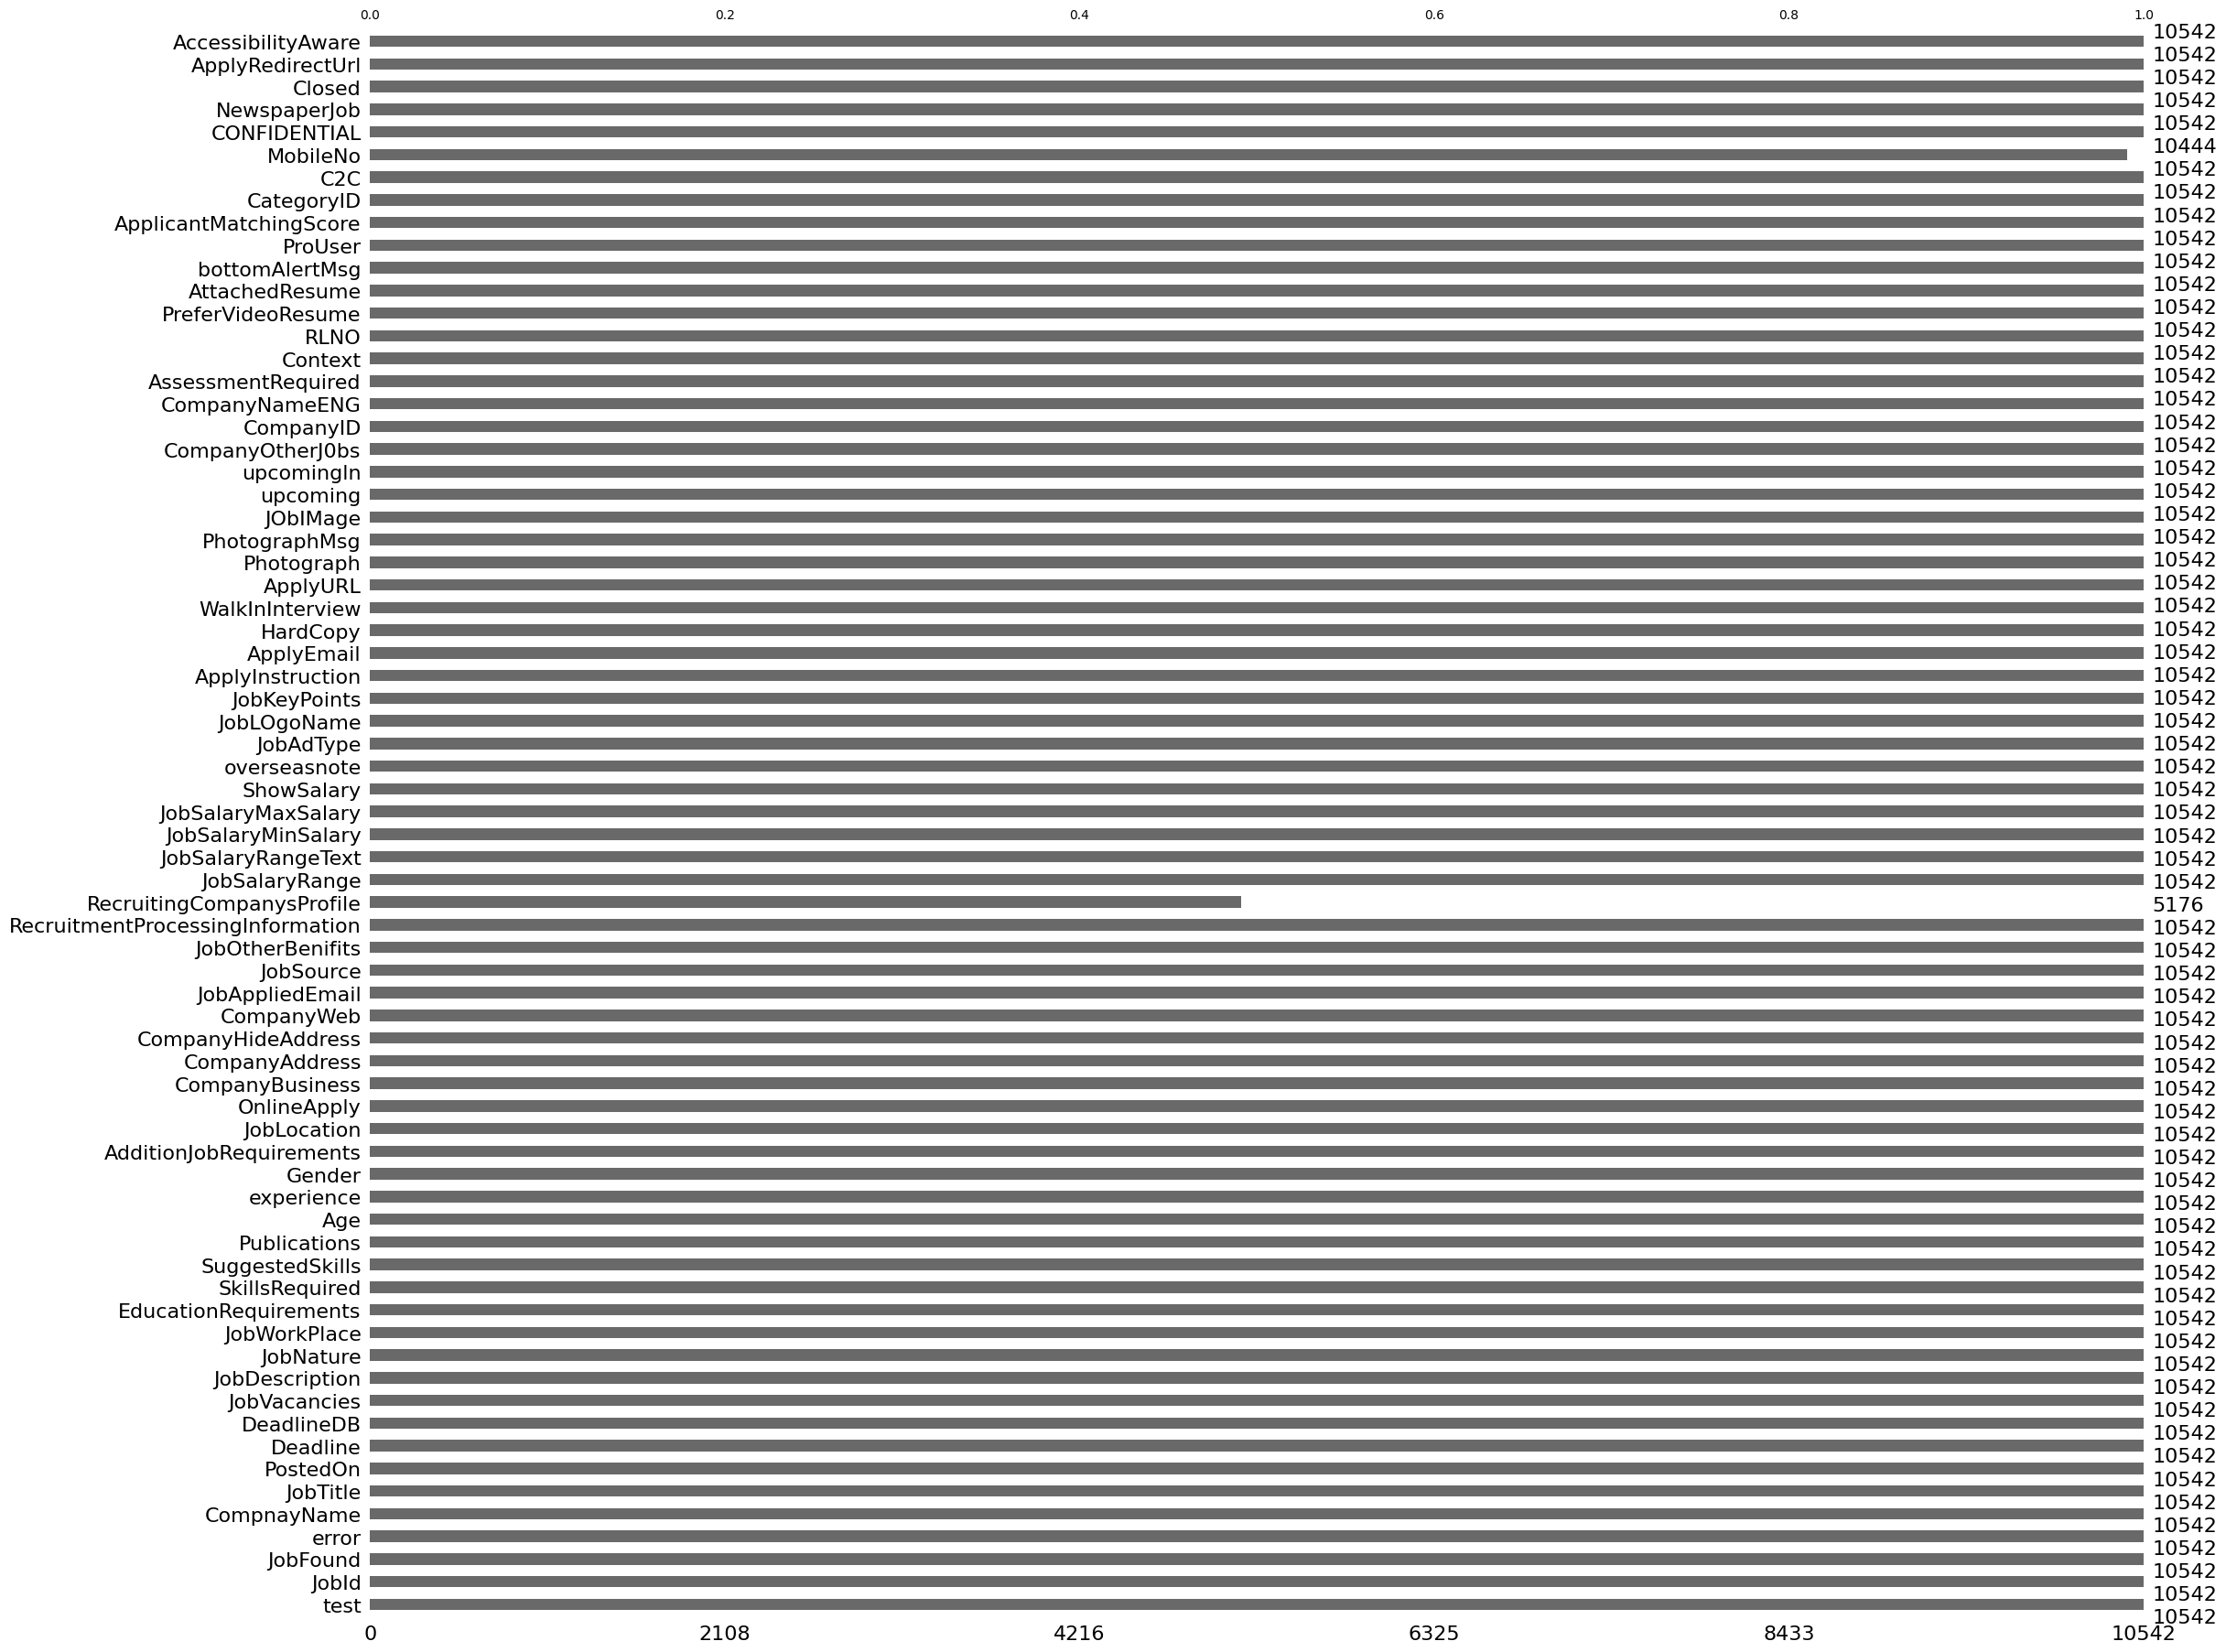

In [181]:
print(df.isnull().sum())

import missingno as msno
msno.bar(df)

In [182]:
# Create a summary table of all features
feature_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes,
    'Non-Null Count': df.count(),
    # We use .apply(lambda x: str(x)) to handle the list columns
    'Unique Values': df.apply(lambda x: x.map(str).nunique()), 
    'Missing Values': df.isnull().sum()
}).reset_index(drop=True)

# Display the whole list
print(feature_info.to_string())

                         Column Name Data Type  Non-Null Count  Unique Values  Missing Values
0                               test     int64           10542              3               0
1                              JobId     int64           10542          10511               0
2                           JobFound    object           10542              1               0
3                              error     int64           10542              1               0
4                        CompnayName    object           10542           5099               0
5                           JobTitle    object           10542           8156               0
6                           PostedOn    object           10542            167               0
7                           Deadline    object           10542            206               0
8                         DeadlineDB    object           10542            232               0
9                       JobVacancies    object           105

In [183]:
import pandas as pd
import json


# List A: Constant columns & Administrative flags
constant_and_admin_cols = [
    'test', 'JobFound', 'error', 'Publications', 'RecruitmentProcessingInformation',
    'upcoming', 'upcomingln', 'AssessmentRequired', 'Context', 'AttachedResume',
    'bottomAlertMsg', 'ProUser', 'ApplicantMatchingScore', 'Closed', 
    'RecruitingCompanysProfile', 'overseasnote', 'ShowSalary', 'JobAdType',
    'C2C', 'CONFIDENTIAL', 'NewspaperJob', 'AccessibilityAware'
]

# List B: Unique IDs, URLs, and Media
ids_urls_media_cols = [
    'JobId', 'ApplyRedirectUrl', 'ApplyURL', 'JobLOgoName', 
    'JObIMage', 'Photograph', 'PhotographMsg', 'RLNO', 
    'CompanyID', 'CompanyOtherJ0bs', 'JobSource'
]

# List C: PII & Contact Details
contact_cols = [
    'MobileNo', 'ApplyEmail', 'JobAppliedEmail', 
    'CompanyAddress', 'CompanyWeb', 'HardCopy', 
    'WalkInInterview', 'ApplyInstruction'
]

# Combine all lists
cols_to_drop = constant_and_admin_cols + ids_urls_media_cols + contact_cols

# 3. Drop the columns
df_cleaned = df.drop(columns=cols_to_drop, errors='ignore')

# 4. Handle Specific Data formatting
# Convert experience to string (often mixed types in JSON)
if 'experience' in df_cleaned.columns:
    df_cleaned['experience'] = df_cleaned['experience'].astype(str)

# 5. Review the Result
print(f"Cleaned Data Shape: {df_cleaned.shape}")
print("-" * 30)
print("Remaining Columns (Features for Training):")
print(df_cleaned.columns.tolist())

# Show first 3 rows
print("-" * 30)
print(df_cleaned.head(3))

Cleaned Data Shape: (10542, 29)
------------------------------
Remaining Columns (Features for Training):
['CompnayName', 'JobTitle', 'PostedOn', 'Deadline', 'DeadlineDB', 'JobVacancies', 'JobDescription', 'JobNature', 'JobWorkPlace', 'EducationRequirements', 'SkillsRequired', 'SuggestedSkills', 'Age', 'experience', 'Gender', 'AdditionJobRequirements', 'JobLocation', 'OnlineApply', 'CompanyBusiness', 'CompanyHideAddress', 'JobOtherBenifits', 'JobSalaryRange', 'JobSalaryRangeText', 'JobSalaryMinSalary', 'JobSalaryMaxSalary', 'JobKeyPoints', 'CompanyNameENG', 'PreferVideoResume', 'CategoryID']
------------------------------
                   CompnayName                                   JobTitle  \
0               RK Supply Ltd.            Data Analyst / Accounts Officer   
1          Pridesys IT Limited                 Processor/Senior Processor   
2  Aalok Healthcare & Hospital  Assistant Manager (Customer Care / Admin)   

      PostedOn      Deadline           DeadlineDB JobVacancie

In [184]:
df_cleaned

,CompnayName,JobTitle,PostedOn,Deadline,DeadlineDB,JobVacancies,JobDescription,JobNature,JobWorkPlace,EducationRequirements,...,CompanyHideAddress,JobOtherBenifits,JobSalaryRange,JobSalaryRangeText,JobSalaryMinSalary,JobSalaryMaxSalary,JobKeyPoints,CompanyNameENG,PreferVideoResume,CategoryID
0,RK Supply Ltd.,Data Analyst / Accounts Officer,"Dec 6, 2025","Dec 31, 2025",12/31/2025 00:00:00,6,"<p><strong><span style=""color:rgb(51, 51, 51);...",Full Time,Work at office,<ul><ul><li>Bachelor of Business Administratio...,...,True,,Tk. 20000 - 35000 (Monthly),,20000,35000,"<p><strong><span style=""color:rgb(51, 51, 51)""...",RK Supply Ltd.,0,8
1,Pridesys IT Limited,Processor/Senior Processor,"Dec 6, 2025","Jan 5, 2026",01/05/2026 00:00:00,2,<ul><li>Review property preservation work orde...,Full Time,Work at office,<ul><ul><li>Bachelor/Honors</li></ul></ul>,...,False,<ul><li>Salary Review: Yearly</li><li>Festival...,Negotiable,,0,0,,Pridesys IT Limited,0,8
2,Aalok Healthcare & Hospital,Assistant Manager (Customer Care / Admin),"Dec 6, 2025","Dec 26, 2025",12/26/2025 00:00:00,4,<h3>Shift Management and Operational Leadershi...,Full Time,Work at office,<ul><ul><li>Masters</li></ul></ul>,...,False,<ul><li>Provident fund</li><li>Salary Review: ...,--,,0,0,,Aalok Healthcare & Hospital,1,11
3,Eureka food and beverage,Sales Representative (SR),"Dec 6, 2025","Jan 5, 2026",01/05/2026 00:00:00,--,<p><strong>দায়িত্ব ও কর্তব্য:</strong></p><ul...,Full Time,,<ul><ul><li>SSC</li><li>HSC</li><li>Bachelor/H...,...,False,<ul><ul><li><p>অন্যান্য সুবিধা: আলোচনা সাপেক্ষ...,Tk. 18000 - 22000 (Monthly),,18000,22000,,Eureka food and beverage,1,84
4,Rancon Holdings Limited,Sales Hero (Sales Executive - Freshers) RANGS ...,"Dec 6, 2025","Dec 31, 2025",12/31/2025 00:00:00,20,<ul><li>Greet and assist walk-in customers wit...,Full Time,Work at office,<ul><ul><li>Bachelor/Honors</li></ul></ul>,...,False,"<ul><li>T/A,Mobile bill,Performance bonus</li>...",Tk. 20000 - 20000 (Monthly),,20000,20000,,Rancon Holdings Limited,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10537,BrandEdge Communication Ltd.,Strategic Planner,"Dec 23, 2025","Jan 22, 2026",2026-01-22,1,"<p><strong style=""color: rgb(106, 115, 129);"">...",Full Time,Work at office,<ul><li>Bachelor/Honors</li></ul>,...,False,,Negotiable,Negotiable,0,0,,BrandEdge Communication Ltd.,1,0
10538,Marine Electronics Service; (A Group Nautika ...,Sales Executive,"Dec 23, 2025","Jan 22, 2026",2026-01-22,--,<p>Marine Electronics Service is seeking young...,Full Time,,<ul><li>Bachelor of Science (BSc) in Electrica...,...,True,"<ul><ul><li><p>Salary: BDT 22,000 - 25,000 (ba...",Tk. 22000 - 25000 (Monthly),Tk. 22000 - 25000 (Monthly),22000,25000,,Marine Electronics Service; (A Group Nautika ...,0,0
10539,PLAYD8 LTD,SEO and Digital Content Specialist,"Dec 23, 2025","Jan 22, 2026",2026-01-22,1,<p>PlayD8 Ltd is seeking a tech-savvy and crea...,Full Time,Work from home,<ul><li>Bachelor of Science (BSc) in Computer ...,...,False,,Tk. 35000 - 50000 (Monthly),Tk. 35000 - 50000 (Monthly),35000,50000,,PLAYD8 LTD,1,0
10540,BrandEdge Communication Ltd.,2D & 3D Designer - Event Activation,"Dec 23, 2025","Jan 22, 2026",2026-01-22,2,<p></p>,Full Time,Work at office,<ul><li>Bachelor of Fine Arts (B.F.A) (Optiona...,...,False,,Negotiable,Negotiable,0,0,,BrandEdge Communication Ltd.,0,0


In [185]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10542 entries, 0 to 10541
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CompnayName              10542 non-null  object
 1   JobTitle                 10542 non-null  object
 2   PostedOn                 10542 non-null  object
 3   Deadline                 10542 non-null  object
 4   DeadlineDB               10542 non-null  object
 5   JobVacancies             10542 non-null  object
 6   JobDescription           10542 non-null  object
 7   JobNature                10542 non-null  object
 8   JobWorkPlace             10542 non-null  object
 9   EducationRequirements    10542 non-null  object
 10  SkillsRequired           10542 non-null  object
 11  SuggestedSkills          10542 non-null  object
 12  Age                      10542 non-null  object
 13  experience               10542 non-null  object
 14  Gender                   10542 non-nul

In [186]:
!pip install beautifulsoup4
!pip install lxml


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# **The "Hidden" Null Check**

In [187]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re



# Create a copy to work on
df_clean = df.copy()

print(f"Original Shape: {df_clean.shape}")


Original Shape: (10542, 70)


In [188]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re



# 2.Text cleaning Function
def strip_html(text):
    if not isinstance(text, str): return text
    if '<' not in text or '>' not in text: return text
    try:
        soup = BeautifulSoup(text, "html.parser")
        clean_text = soup.get_text(separator=" ")
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        return clean_text
    except: return text

# ৩. নাম্বার এক্সট্রাকশন ফাংশন (Age এবং Experience এর জন্য)
def extract_range(text):
    if pd.isna(text) or text == "Any" or text == "":
        return None, None
    
    # টেক্সট থেকে সব সংখ্যা খুঁজে বের করা (যেমন: "25 to 30" -> [25, 30])
    numbers = re.findall(r'\d+', str(text))
    
    if not numbers:
        return None, None
    
    nums = [int(n) for n in numbers]
    
    if len(nums) >= 2:
        return nums[0], nums[1] # Min, Max
    elif len(nums) == 1:
        # যদি শুধু একটি সংখ্যা থাকে (যেমন: "At least 25")
        return nums[0], None
    return None, None

# ৪. ক্লিনিং প্রসেস শুরু
# ---------------------------------------------------------

# HTML পরিষ্কার করা
html_columns = ['JobDescription', 'JobKeyPoints', 'EducationRequirements', 'JobOtherBenifits']
for col in html_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(strip_html)

# লজিক্যাল নাল (Missing values) হ্যান্ডেল করা
missing_indicators = ["--", "N/A", "n/a", "Not Applicable", "[]", "", " ", "0000-00-00"]
df_clean.replace(missing_indicators, np.nan, inplace=True)

# স্যালারি এবং ভ্যাকেন্সি ঠিক করা
if 'JobSalaryMinSalary' in df_clean.columns:
    df_clean['JobSalaryMinSalary'] = df_clean['JobSalaryMinSalary'].replace(0, np.nan)
if 'JobSalaryMaxSalary' in df_clean.columns:
    df_clean['JobSalaryMaxSalary'] = df_clean['JobSalaryMaxSalary'].replace(0, np.nan)
if 'JobVacancies' in df_clean.columns:
    df_clean['JobVacancies'] = pd.to_numeric(df_clean['JobVacancies'], errors='coerce')

# ৫. বয়স (Age) এবং অভিজ্ঞতা (Experience) পার্স করা
# ---------------------------------------------------------

# Age পার্সিং
if 'Age' in df_clean.columns:
    print("Extracting Age Range...")
    age_data = df_clean['Age'].apply(extract_range)
    df_clean['MinAge'] = age_data.apply(lambda x: x[0])
    df_clean['MaxAge'] = age_data.apply(lambda x: x[1])

# Experience পার্সিং (আপনার আগের লজিক অনুযায়ী)
if 'experience' in df_clean.columns:
    print("Extracting Experience Range...")
    exp_data = df_clean['experience'].apply(extract_range)
    df_clean['MinExperience'] = exp_data.apply(lambda x: x[0])
    df_clean['MaxExperience'] = exp_data.apply(lambda x: x[1])

# ৬. ফলাফল দেখা
# ---------------------------------------------------------
print("\n" + "="*40)
print("UPDATED CLEANING SUMMARY")
print("="*40)
print(df_clean[['Age', 'MinAge', 'MaxAge']].head(10))

# এখন আপনি চাইলে মেইন Age এবং experience কলাম ড্রপ করে দিতে পারেন
df_clean.drop(columns=['Age'], inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_2936\1244205997.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean.replace(missing_indicators, np.nan, inplace=True)


Extracting Age Range...
Extracting Experience Range...

UPDATED CLEANING SUMMARY
                 Age  MinAge  MaxAge
0     20 to 35 years    20.0    35.0
1     20 to 35 years    20.0    35.0
2                 Na     NaN     NaN
3     22 to 40 years    22.0    40.0
4     24 to 30 years    24.0    30.0
5     25 to 38 years    25.0    38.0
6  At least 27 years    27.0     NaN
7                 Na     NaN     NaN
8  At least 28 years    28.0     NaN
9     20 to 35 years    20.0    35.0


In [189]:
df_clean.head()

,test,JobId,JobFound,error,CompnayName,JobTitle,PostedOn,Deadline,DeadlineDB,JobVacancies,...,MobileNo,CONFIDENTIAL,NewspaperJob,Closed,ApplyRedirectUrl,AccessibilityAware,MinAge,MaxAge,MinExperience,MaxExperience
0,1,1436370,True,0,RK Supply Ltd.,Data Analyst / Accounts Officer,"Dec 6, 2025","Dec 31, 2025",12/31/2025 00:00:00,6.0,...,NaN,NaN,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?c7`6...,[],20.0,35.0,1.0,2.0
1,1,1437042,True,0,Pridesys IT Limited,Processor/Senior Processor,"Dec 6, 2025","Jan 5, 2026",01/05/2026 00:00:00,2.0,...,NaN,NaN,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?a4]7...,[],20.0,35.0,2.0,NaN
2,1,1437039,True,0,Aalok Healthcare & Hospital,Assistant Manager (Customer Care / Admin),"Dec 6, 2025","Dec 26, 2025",12/26/2025 00:00:00,4.0,...,NaN,NaN,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3_7a...,[{'Name': 'Do you have Disability Inclusion Po...,NaN,NaN,3.0,5.0
3,1,1436999,True,0,Eureka food and beverage,Sales Representative (SR),"Dec 6, 2025","Jan 5, 2026",01/05/2026 00:00:00,NaN,...,NaN,NaN,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?`9_6...,[],22.0,40.0,2.0,5.0
4,1,1437032,True,0,Rancon Holdings Limited,Sales Hero (Sales Executive - Freshers) RANGS ...,"Dec 6, 2025","Dec 31, 2025",12/31/2025 00:00:00,20.0,...,NaN,NaN,False,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3\7[...,[],24.0,30.0,NaN,NaN


# **Feature Audit for Recommender Utility**

In [190]:
import pandas as pd
import numpy as np
import re

# ==========================================
# PHASE 2: FEATURE AUDIT & CLEANING
# ==========================================

# Assuming 'df_clean' comes from Phase 1
# If you are starting fresh, uncomment the line below:
# df_clean = pd.read_json('Realtime_Jobs_Data.json')

# 1. Define Columns to DROP (Noise, PII, Artifacts)
# ---------------------------------------------------------
# We RETAIN 'JobId' and 'CompanyID' as requested.
cols_to_drop = [
    # Administrative / Scraper Artifacts
    'test', 'JobFound', 'error', 'JobSource', 'JobAdType', 
    'RecruitmentProcessingInformation', 'RecruitingCompanysProfile',
    'ApplicantMatchingScore', 'ProUser', 'bottomAlertMsg',
    'CONFIDENTIAL', 'NewspaperJob', 'Closed', 'AccessibilityAware',
    'C2C', 'Publications', 'AssessmentRequired', 'Context', 'RLNO',
    
    # Media & Display Assets (Not needed for logic)
    'JobLOgoName', 'JObIMage', 'Photograph', 'PhotographMsg',
    'upcoming', 'upcomingln', 'PreferVideoResume', 'AttachedResume',
    
    # Contact / PII (Keep URLs, drop raw contacts)
    'MobileNo', 'ApplyEmail', 'JobAppliedEmail', 
    'HardCopy', 'WalkInInterview', 
    
    # Redundant Dates (Keep DeadlineDB as it's cleaner)
     'Deadline', 'overseasnote' 
]

# 2. Execute Drop & Rename
# ---------------------------------------------------------
# Drop columns that exist in the dataframe
df_audit = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns], errors='ignore')

# Fix Typos (Common in scraped data)
df_audit.rename(columns={
    'CompnayName': 'CompanyName',
    'DeadlineDB': 'Deadline'  # Using the DB version as the main Deadline
}, inplace=True)


# 3. Feature Extraction: Experience
# ---------------------------------------------------------
# Convert text like "1 to 3 year(s)" or "At least 2 years" into Integers
def parse_experience(text):
    if pd.isna(text):
        return None, None
    
    # Regex to find numbers. 
    # Matches "1 to 3", "1-3", "At least 1", "Up to 5"
    numbers = re.findall(r'\d+', str(text))
    
    if not numbers:
        return None, None
    
    # Convert found numbers to integers
    years = [int(n) for n in numbers]
    
    if len(years) == 1:
        # "At least 2 years" -> Min: 2, Max: Null
        return years[0], None
    elif len(years) >= 2:
        # "2 to 5 years" -> Min: 2, Max: 5
        return years[0], years[1]
    
    return None, None

print("Extracting Experience Years...")
# Apply the function and create two new columns
exp_data = df_audit['experience'].apply(parse_experience)
df_audit['MinExperience'] = exp_data.apply(lambda x: x[0])
df_audit['MaxExperience'] = exp_data.apply(lambda x: x[1])

# Drop the original text column to clean up
df_audit.drop(columns=['experience'], inplace=True)


# 4. Standardize Dates
# ---------------------------------------------------------
if 'Deadline' in df_audit.columns:
    df_audit['Deadline'] = pd.to_datetime(df_audit['Deadline'], errors='coerce')


# 5. Final Sparsity Audit
# ---------------------------------------------------------
# Check how much data we actually have after cleaning
sparsity = df_audit.isnull().mean() * 100
sparsity = sparsity[sparsity > 0].sort_values(ascending=False)

print("\n" + "="*40)
print("PHASE 2 AUDIT: DATASET STATUS")
print("="*40)
print(f"Remaining Columns: {df_audit.shape[1]}")
print(f"Total Rows: {df_audit.shape[0]}")
print("\nTop 5 Sparse Features (% Missing):")
print(sparsity.head(5))

# Sanity Check: Ensure Primary Keys are present
keys_present = all(col in df_audit.columns for col in ['JobId', 'CompanyID'])
print(f"\nPrimary Keys Preserved: {keys_present}")

# Show the new structure
print("\nNew DataFrame Head:")
print(df_audit[['JobId', 'JobTitle', 'MinExperience', 'MaxExperience','MinAge','MaxAge']].head())

Extracting Experience Years...

PHASE 2 AUDIT: DATASET STATUS
Remaining Columns: 38
Total Rows: 10542

Top 5 Sparse Features (% Missing):
ApplyURL              97.837223
JobKeyPoints          88.778220
CompanyWeb            80.762664
ApplyInstruction      75.042686
JobSalaryMinSalary    72.538418
dtype: float64

Primary Keys Preserved: True

New DataFrame Head:
     JobId                                           JobTitle  MinExperience  \
0  1436370                    Data Analyst / Accounts Officer            1.0   
1  1437042                         Processor/Senior Processor            2.0   
2  1437039          Assistant Manager (Customer Care / Admin)            3.0   
3  1436999                          Sales Representative (SR)            2.0   
4  1437032  Sales Hero (Sales Executive - Freshers) RANGS ...            NaN   

   MaxExperience  MinAge  MaxAge  
0            2.0    20.0    35.0  
1            NaN    20.0    35.0  
2            5.0     NaN     NaN  
3            5.

In [191]:
df_audit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10542 entries, 0 to 10541
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   JobId                    10542 non-null  int64         
 1   CompanyName              10542 non-null  object        
 2   JobTitle                 10542 non-null  object        
 3   PostedOn                 10542 non-null  object        
 4   Deadline                 5176 non-null   datetime64[ns]
 5   JobVacancies             6806 non-null   float64       
 6   JobDescription           10150 non-null  object        
 7   JobNature                10542 non-null  object        
 8   JobWorkPlace             8235 non-null   object        
 9   EducationRequirements    9642 non-null   object        
 10  SkillsRequired           5194 non-null   object        
 11  SuggestedSkills          8272 non-null   object        
 12  Gender                   10542 n

In [192]:
df_audit

,JobId,CompanyName,JobTitle,PostedOn,Deadline,JobVacancies,JobDescription,JobNature,JobWorkPlace,EducationRequirements,...,ApplyURL,CompanyOtherJ0bs,CompanyID,CompanyNameENG,CategoryID,ApplyRedirectUrl,MinAge,MaxAge,MinExperience,MaxExperience
0,1436370,RK Supply Ltd.,Data Analyst / Accounts Officer,"Dec 6, 2025",2025-12-31,6.0,"RK Supply Ltd. (Company No. 09740433), establi...",Full Time,Work at office,Bachelor of Business Administration (BBA) Bach...,...,NaN,0,109093,RK Supply Ltd.,8,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?c7`6...,20.0,35.0,1.0,2.0
1,1437042,Pridesys IT Limited,Processor/Senior Processor,"Dec 6, 2025",2026-01-05,2.0,Review property preservation work orders submi...,Full Time,Work at office,Bachelor/Honors,...,NaN,0,38072,Pridesys IT Limited,8,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?a4]7...,20.0,35.0,2.0,NaN
2,1437039,Aalok Healthcare & Hospital,Assistant Manager (Customer Care / Admin),"Dec 6, 2025",2025-12-26,4.0,Shift Management and Operational Leadership (2...,Full Time,Work at office,Masters,...,NaN,4,92299,Aalok Healthcare & Hospital,11,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3_7a...,NaN,NaN,3.0,5.0
3,1436999,Eureka food and beverage,Sales Representative (SR),"Dec 6, 2025",2026-01-05,NaN,দায়িত্ব ও কর্তব্য: কোম্পানির পণ্য বিক্রয় করা...,Full Time,NaN,SSC HSC Bachelor/Honors,...,NaN,0,179518,Eureka food and beverage,84,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?`9_6...,22.0,40.0,2.0,5.0
4,1437032,Rancon Holdings Limited,Sales Hero (Sales Executive - Freshers) RANGS ...,"Dec 6, 2025",2025-12-31,20.0,Greet and assist walk-in customers with a frie...,Full Time,Work at office,Bachelor/Honors,...,NaN,8,45797,Rancon Holdings Limited,9,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3\7[...,24.0,30.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10537,1442972,BrandEdge Communication Ltd.,Strategic Planner,"Dec 23, 2025",NaT,1.0,Description We are seeking a Strategic Planner...,Full Time,Work at office,Bachelor/Honors,...,NaN,1,193811,BrandEdge Communication Ltd.,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?b2[9...,NaN,NaN,1.0,4.0
10538,1442968,Marine Electronics Service; (A Group Nautika ...,Sales Executive,"Dec 23, 2025",NaT,NaN,"Marine Electronics Service is seeking young, a...",Full Time,NaN,Bachelor of Science (BSc) in Electrical & Elec...,...,NaN,0,64506,Marine Electronics Service; (A Group Nautika ...,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?\8b9...,NaN,NaN,1.0,2.0
10539,1412021,PLAYD8 LTD,SEO and Digital Content Specialist,"Dec 23, 2025",NaT,1.0,PlayD8 Ltd is seeking a tech-savvy and creativ...,Full Time,Work from home,Bachelor of Science (BSc) in Computer Science ...,...,NaN,0,137259,PLAYD8 LTD,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?1Z0]...,35.0,NaN,3.0,NaN
10540,1442798,BrandEdge Communication Ltd.,2D & 3D Designer - Event Activation,"Dec 23, 2025",NaT,2.0,NaN,Full Time,Work at office,Bachelor of Fine Arts (B.F.A) (Optional),...,NaN,1,193811,BrandEdge Communication Ltd.,0,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?8]7^...,NaN,NaN,3.0,NaN


In [193]:
# Select multiple columns by passing a list
skills_view = df_audit[['OnlineApply', 'ShowSalary']]

# Display the first 5 rows
skills_view

,OnlineApply,ShowSalary
0,True,1
1,True,1
2,True,0
3,True,1
4,True,1
...,...,...
10537,True,1
10538,True,1
10539,True,1
10540,True,1


# **Custom Feature Selection**

In [194]:
# ==========================================
# PHASE 2.1: CUSTOM FEATURE SELECTION
# ==========================================

# আপনি যে কলামগুলো সুনির্দিষ্টভাবে বাদ দিতে চেয়েছেন এবং 
# যেগুলো প্রজেক্টের জন্য অপ্রয়োজনীয় সেগুলোর একটি লিস্ট
cols_to_drop_final = [
    'ShowSalary',            # আপনার লিস্টের ৩ নম্বর (অপ্রয়োজনীয় ফ্ল্যাগ)
    'CompanyHideAddress',    # আপনার লিস্টের ৪ নম্বর (গোপনীয়তা বিষয়ক, লজিকে লাগবে না)
    'ApplyInstruction',      # আপনার লিস্টের ৬ নম্বর (অতিরিক্ত বড় টেক্সট)
    'CategoryID',            # আপনার লিস্টের ৮ নম্বর (আইডির বদলে নাম রাখা ভালো)
    'OnlineApply',           # ৭ নম্বর লজিক অনুযায়ী (অপ্রয়োজনীয় ফ্ল্যাগ)
    
    # এছাড়াও আরও কিছু টেকনিক্যাল কলাম যা ড্রপ করা ভালো
    'CompanyNameENG', 
    'ApplyURL', 
    'JobSalaryRangeText',
    'JobSalaryRange',
    'CompanyWeb'
]

# ১. ড্রপ অপারেশন
# ---------------------------------------------------------
df_final = df_audit.drop(columns=[c for c in cols_to_drop_final if c in df_audit.columns], errors='ignore')

# ২. গুরুত্বপূর্ণ কলামগুলোর অর্ডার সাজানো (Readability-র জন্য)
# ---------------------------------------------------------
# এটি বাধ্যতামূলক নয়, তবে চ্যাটবটের ডাটা হ্যান্ডেল করতে সুবিধা হবে
important_cols = [
    'CompanyName', 'JobTitle', 
    'JobDescription', 'SkillsRequired', 'SuggestedSkills', 
    'MinExperience', 'MaxExperience', 'JobLocation', 
    'JobNature', 'JobSalaryMinSalary', 'JobSalaryMaxSalary','PostedOn',
    'Deadline', 'EducationRequirements', 'Gender','MinAge','MaxAge', 
    'JobOtherBenifits', 'ApplyRedirectUrl','JobWorkPlace',
]

# শুধুমাত্র যে কলামগুলো বর্তমানে ডাটাফ্রেমে আছে সেগুলোই সিলেক্ট করবে
existing_important_cols = [c for c in important_cols if c in df_final.columns]
df_final = df_final[existing_important_cols]

# ৩. ফাইনাল ডাটাফ্রেমের সামারি
# ---------------------------------------------------------
print("="*40)
print("FINAL DATASET FOR RECOMMENDATION SYSTEM")
print("="*40)
print(f"Total Features Kept: {len(df_final.columns)}")
print(f"Features List: {list(df_final.columns)}")
print(f"\nRemaining Rows: {len(df_final)}")

# প্রথম ৫টি রো দেখে নেওয়া
df_final.head()

FINAL DATASET FOR RECOMMENDATION SYSTEM
Total Features Kept: 20
Features List: ['CompanyName', 'JobTitle', 'JobDescription', 'SkillsRequired', 'SuggestedSkills', 'MinExperience', 'MaxExperience', 'JobLocation', 'JobNature', 'JobSalaryMinSalary', 'JobSalaryMaxSalary', 'PostedOn', 'Deadline', 'EducationRequirements', 'Gender', 'MinAge', 'MaxAge', 'JobOtherBenifits', 'ApplyRedirectUrl', 'JobWorkPlace']

Remaining Rows: 10542


,CompanyName,JobTitle,JobDescription,SkillsRequired,SuggestedSkills,MinExperience,MaxExperience,JobLocation,JobNature,JobSalaryMinSalary,JobSalaryMaxSalary,PostedOn,Deadline,EducationRequirements,Gender,MinAge,MaxAge,JobOtherBenifits,ApplyRedirectUrl,JobWorkPlace
0,RK Supply Ltd.,Data Analyst / Accounts Officer,"RK Supply Ltd. (Company No. 09740433), establi...","Accounting,Accounting Data Entry,Canva Pro,Dat...","Accounting Data Entry,Accounting Software,Acco...",1.0,2.0,Dhaka (Banani),Full Time,20000.0,35000.0,"Dec 6, 2025",2025-12-31,Bachelor of Business Administration (BBA) Bach...,"M,F",20.0,35.0,NaN,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?c7`6...,Work at office
1,Pridesys IT Limited,Processor/Senior Processor,Review property preservation work orders submi...,"Flexibility and Adaptability,Google Sheets,MS ...","Client Service,Property Management,Property Pr...",2.0,NaN,Dhaka (Kawran Bazar),Full Time,NaN,NaN,"Dec 6, 2025",2026-01-05,Bachelor/Honors,M,20.0,35.0,Salary Review: Yearly Festival Bonus: 2 Dinner...,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?a4]7...,Work at office
2,Aalok Healthcare & Hospital,Assistant Manager (Customer Care / Admin),Shift Management and Operational Leadership (2...,"Computer Literacy,Customer Service,Health/ Med...","Administration,Complaint Management,Hospital B...",3.0,5.0,Dhaka (Mirpur),Full Time,NaN,NaN,"Dec 6, 2025",2025-12-26,Masters,M,NaN,NaN,Provident fund Salary Review: Yearly Festival ...,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3_7a...,Work at office
3,Eureka food and beverage,Sales Representative (SR),দায়িত্ব ও কর্তব্য: কোম্পানির পণ্য বিক্রয় করা...,NaN,"Market Research,Marketing,Sales & Marketing,Sa...",2.0,5.0,Anywhere in Bangladesh,Full Time,18000.0,22000.0,"Dec 6, 2025",2026-01-05,SSC HSC Bachelor/Honors,M,22.0,40.0,অন্যান্য সুবিধা: আলোচনা সাপেক্ষে,//mybdjobs.bdjobs.com/mybdjobs/signin.asp?`9_6...,NaN
4,Rancon Holdings Limited,Sales Hero (Sales Executive - Freshers) RANGS ...,Greet and assist walk-in customers with a frie...,NaN,"Marketing and Sales,Retail Sales,Sales,Sales &...",NaN,NaN,Anywhere in Bangladesh,Full Time,20000.0,20000.0,"Dec 6, 2025",2025-12-31,Bachelor/Honors,M,24.0,30.0,"T/A,Mobile bill,Performance bonus Salary Revie...",//mybdjobs.bdjobs.com/mybdjobs/signin.asp?3\7[...,Work at office


# **Word Counts and Common Phrases**

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2488 (\N{BENGALI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2489 (\N{BENGALI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2453 (\N{BENGALI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) 

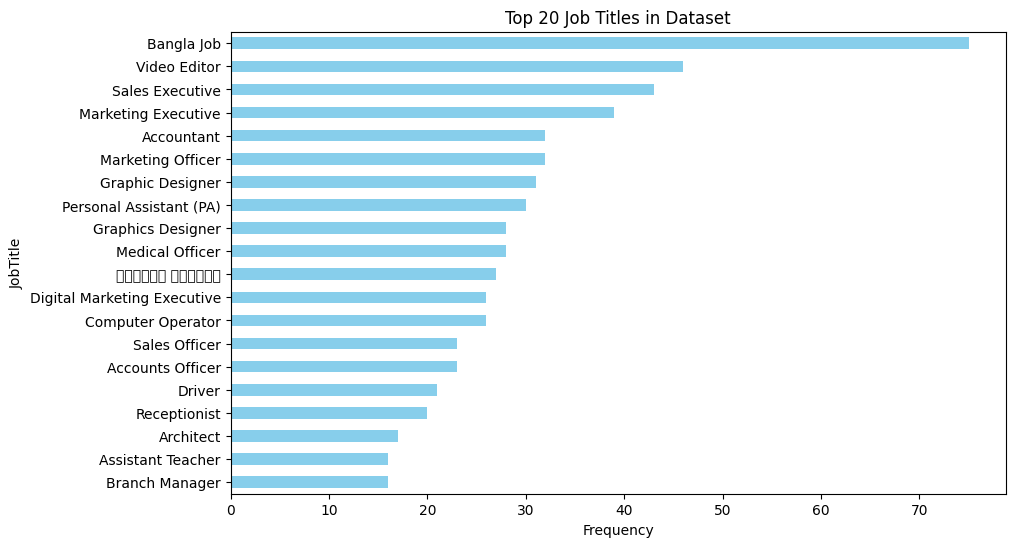

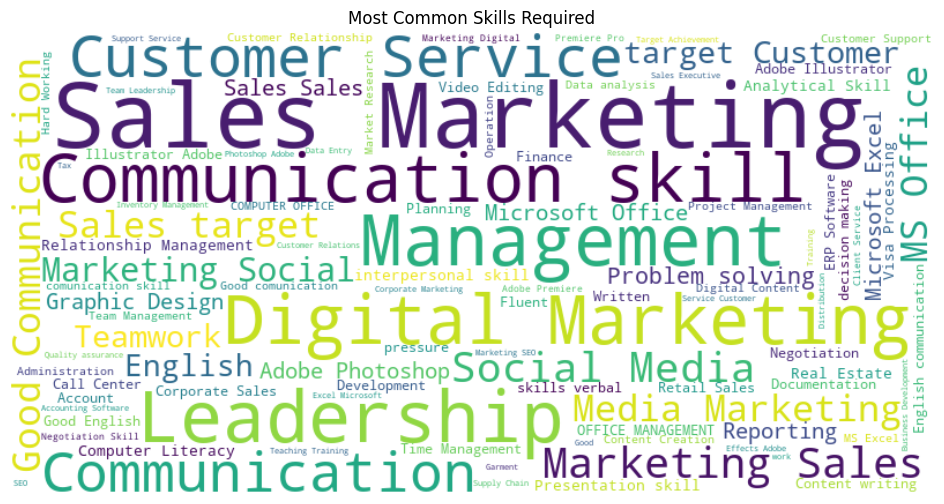

In [195]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# 1. Visualize Top Job Titles
plt.figure(figsize=(10, 6))
df_final['JobTitle'].value_counts().head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Job Titles in Dataset')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.show()

# 2. Word Cloud for Skills (Crucial for Matching)
# We join all text in the SkillsRequired column
skills_text = " ".join(df_final['SkillsRequired'].fillna('').astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='viridis', max_words=100).generate(skills_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Skills Required')
plt.show()

# **Filter Distribution**

C:\Users\User\AppData\Local\Temp\ipykernel_2936\3476858371.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='JobNature', palette='Set2')


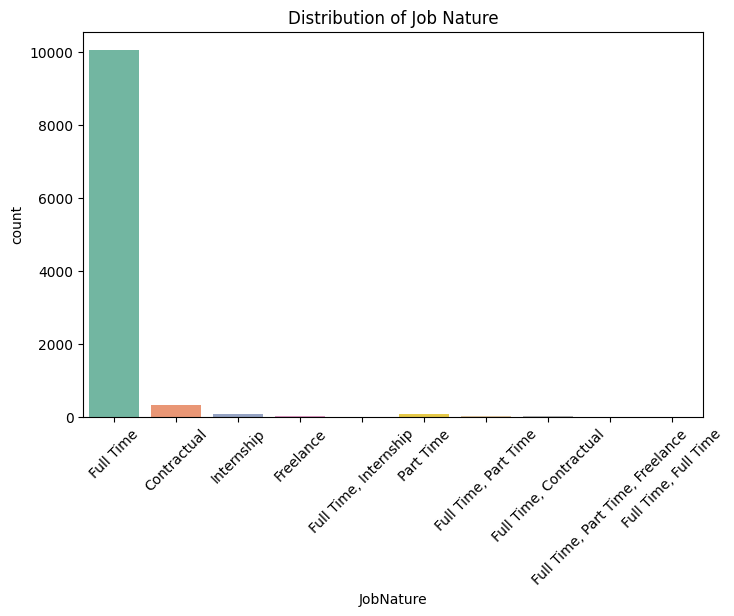

Salary Disclosure Rate:
HasSalary
Hidden/Negotiable    72.528932
Disclosed            27.471068
Name: proportion, dtype: float64


In [196]:
# 3. Analyze Job Nature (Full-time, Part-time, etc.)
plt.figure(figsize=(8, 5))
sns.countplot(data=df_final, x='JobNature', palette='Set2')
plt.title('Distribution of Job Nature')
plt.xticks(rotation=45)
plt.show()

# 4. Analyze Salary Presence
# Since a bot needs to answer "What is the salary?", check how many records have it
df_final['HasSalary'] = df_final['JobSalaryMaxSalary'].apply(lambda x: 'Disclosed' if x > 0 else 'Hidden/Negotiable')
print("Salary Disclosure Rate:")
print(df_final['HasSalary'].value_counts(normalize=True) * 100)

# **Salary Distribution**

C:\Users\User\AppData\Local\Temp\ipykernel_2936\403398488.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['JobSalaryMinSalary'], shade=True, label='Min Salary', color="blue")
C:\Users\User\AppData\Local\Temp\ipykernel_2936\403398488.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['JobSalaryMaxSalary'], shade=True, label='Max Salary', color="green")


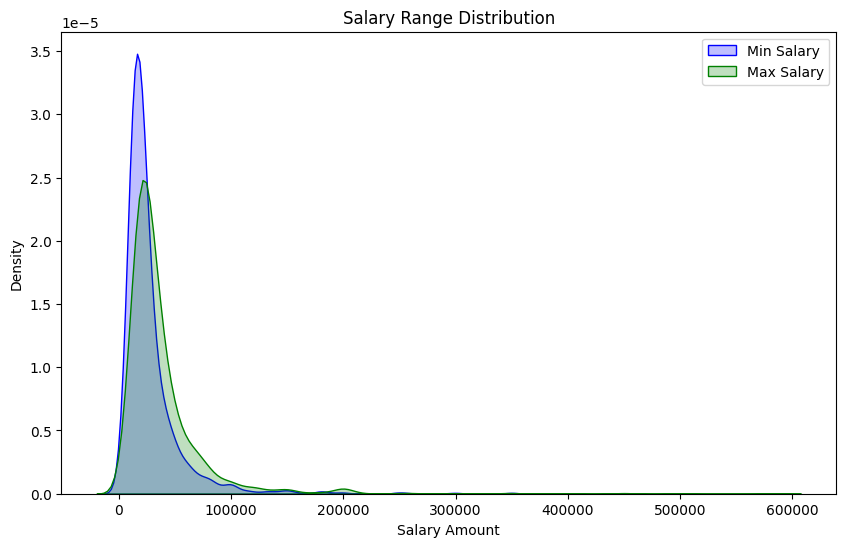

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df_final['JobSalaryMinSalary'], shade=True, label='Min Salary', color="blue")
sns.kdeplot(df_final['JobSalaryMaxSalary'], shade=True, label='Max Salary', color="green")
plt.title('Salary Range Distribution')
plt.xlabel('Salary Amount')
plt.ylabel('Density')
plt.legend()
plt.savefig('salary_distribution.png')

# **Top 20 Job Locations**

In [198]:
unique_locations = df['JobLocation'].unique()
print(unique_locations)
print(df['JobLocation'].nunique())

['Dhaka (Banani)' 'Dhaka (Kawran Bazar)' 'Dhaka (Mirpur)' ...
 'Brahmanbaria, Chattogram (Chattogram Sadar), Cox`s Bazar, Cumilla, Sylhet'
 'Dhaka (Agargaon, Banani, Cantonment, Dhanmondi, Kawran Bazar, Khilkhet, Mirpur, Mohakhali, Mohammadpur, Pallabi, Uttara)'
 'Rajshahi (Rajshahi Sadar), Rangpur (Rangpur Sadar)']
1094


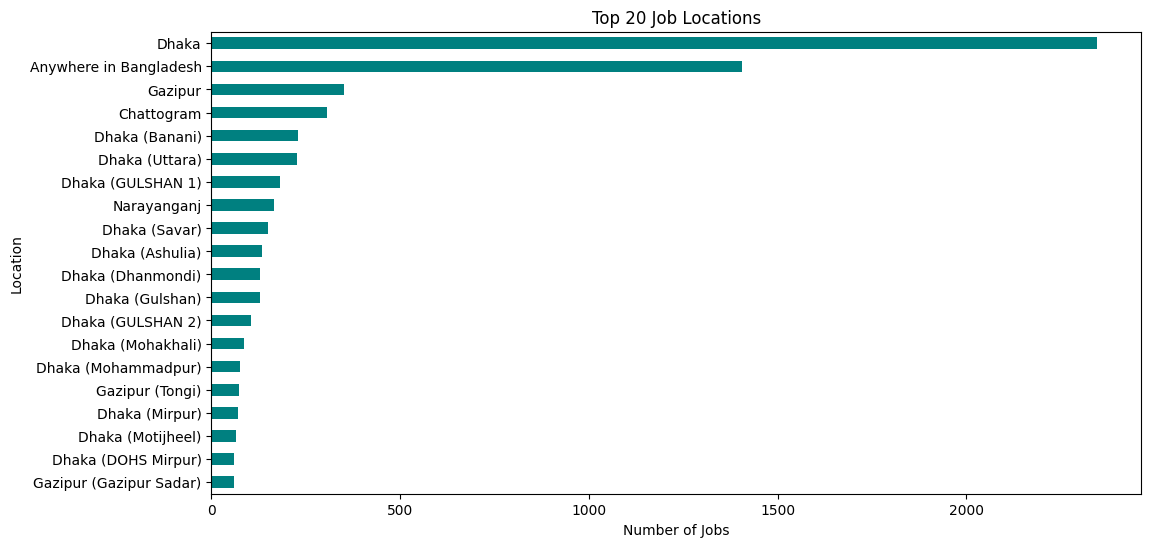

In [199]:
plt.figure(figsize=(12, 6))
df_final['JobLocation'].value_counts().head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Job Locations')
plt.xlabel('Number of Jobs')
plt.ylabel('Location')
plt.gca().invert_yaxis()
plt.savefig('top_locations.png')

# **Experiment Requirement Plot**

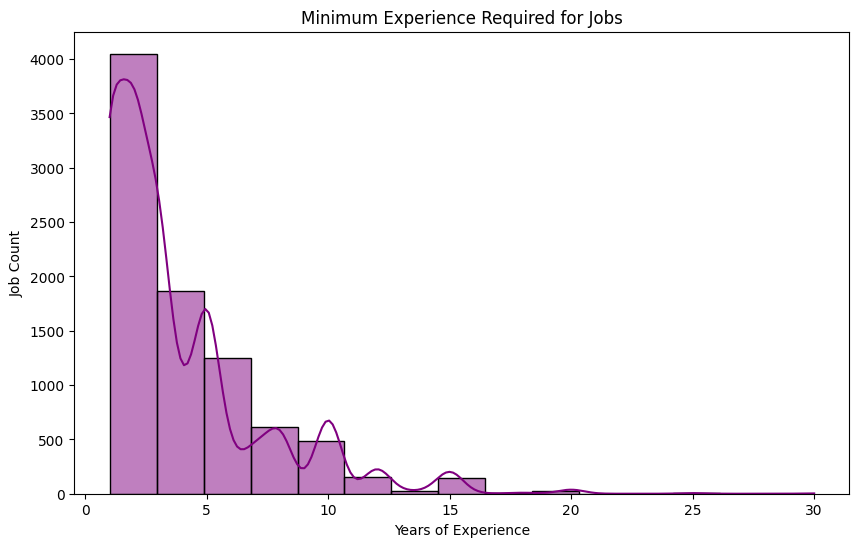

In [200]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['MinExperience'].dropna(), bins=15, color='purple', kde=True)
plt.title('Minimum Experience Required for Jobs')
plt.xlabel('Years of Experience')
plt.ylabel('Job Count')
plt.savefig('experience_distribution.png')

C:\Users\User\AppData\Local\Temp\ipykernel_2936\4050401057.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loc_salary_stats.values, y=loc_salary_stats.index, palette='magma')


Plot saved as 'salary_by_location.png'


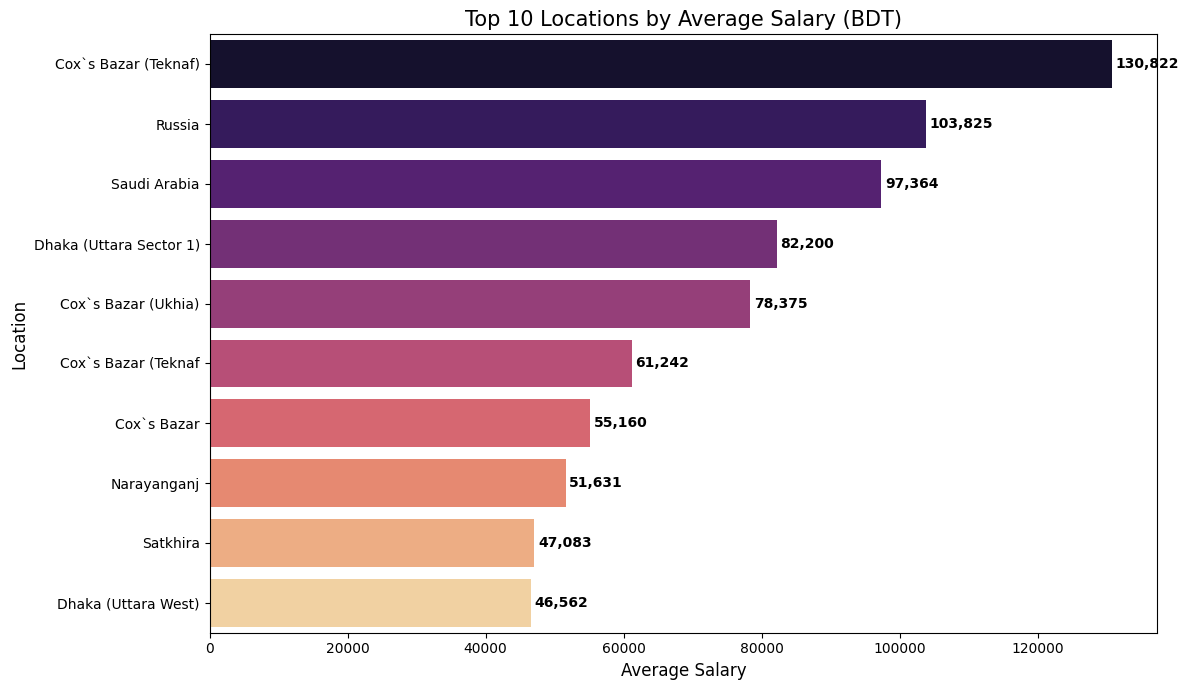

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ১. স্যালারি এবং লোকেশন ডেটা প্রসেসিং
# ---------------------------------------------------------

# Average Salary বের করা (যেখানে স্যালারি ডেটা আছে)
df_final['AvgSalary'] = (df_final['JobSalaryMinSalary'] + df_final['JobSalaryMaxSalary']) / 2

# লোকেশন ডেটা ক্লিন করা (অতিরিক্ত স্পেস বা কমা থাকলে ঠিক করা)
df_final['CleanLocation'] = df_final['JobLocation'].str.split(',').str[0].str.strip()

# যে ডেটাতে স্যালারি এবং লোকেশন দুইটাই আছে সেগুলো ফিল্টার করা
salary_loc_df = df_final.dropna(subset=['AvgSalary', 'CleanLocation'])

# ২. টপ ১০ লোকেশনের গড় স্যালারি বের করা
# ---------------------------------------------------------
# শুধু সেই লোকেশনগুলো নেওয়া যেখানে অন্তত ৫টি জব আছে (যাতে রেজাল্ট বিশ্বাসযোগ্য হয়)
loc_counts = salary_loc_df['CleanLocation'].value_counts()
top_locations = loc_counts[loc_counts >= 5].index

filtered_salary_df = salary_loc_df[salary_loc_df['CleanLocation'].isin(top_locations)]

# লোকেশন অনুযায়ী গড় স্যালারি ক্যালকুলেট করা
loc_salary_stats = filtered_salary_df.groupby('CleanLocation')['AvgSalary'].mean().sort_values(ascending=False).head(10)

# visualization
plt.figure(figsize=(12, 7))
sns.barplot(x=loc_salary_stats.values, y=loc_salary_stats.index, palette='magma')

plt.title('Top 10 Locations by Average Salary (BDT)', fontsize=15)
plt.xlabel('Average Salary', fontsize=12)
plt.ylabel('Location', fontsize=12)

# writing salaries values in graph
for i, v in enumerate(loc_salary_stats.values):
    plt.text(v + 500, i, f'{int(v):,}', color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('salary_by_location.png')
print("Plot saved as 'salary_by_location.png'")

# **Gender Distribution**

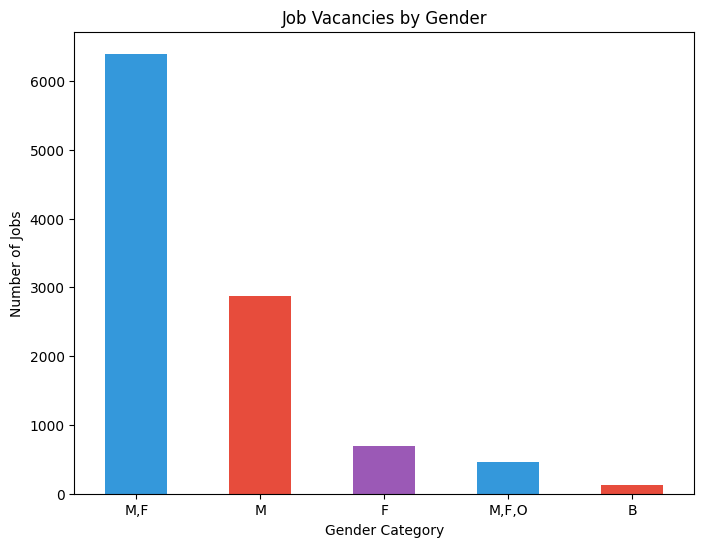

In [202]:
plt.figure(figsize=(8, 6))
df_final['Gender'].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c', '#9b59b6'])
plt.title('Job Vacancies by Gender')
plt.xlabel('Gender Category')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=0)
plt.savefig('gender_distribution.png')

In [203]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10542 entries, 0 to 10541
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CompanyName            10542 non-null  object        
 1   JobTitle               10542 non-null  object        
 2   JobDescription         10150 non-null  object        
 3   SkillsRequired         5194 non-null   object        
 4   SuggestedSkills        8272 non-null   object        
 5   MinExperience          8623 non-null   float64       
 6   MaxExperience          4688 non-null   float64       
 7   JobLocation            10542 non-null  object        
 8   JobNature              10542 non-null  object        
 9   JobSalaryMinSalary     2895 non-null   float64       
 10  JobSalaryMaxSalary     2896 non-null   float64       
 11  PostedOn               10542 non-null  object        
 12  Deadline               5176 non-null   datetime64[ns]
 13  E

# **Workplace Analysis**

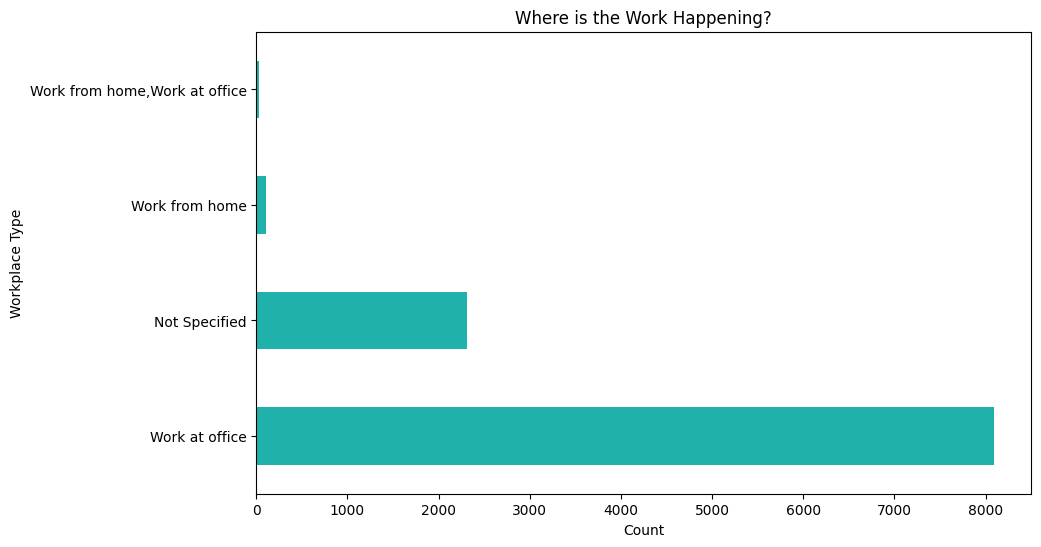

In [204]:
plt.figure(figsize=(10, 6))
df_final['JobWorkPlace'].fillna('Not Specified').value_counts().head(5).plot(kind='barh', color='lightseagreen')
plt.title('Where is the Work Happening?')
plt.xlabel('Count')
plt.ylabel('Workplace Type')
plt.savefig('workplace_type.png')

# **Top 10 Educational Requirements**

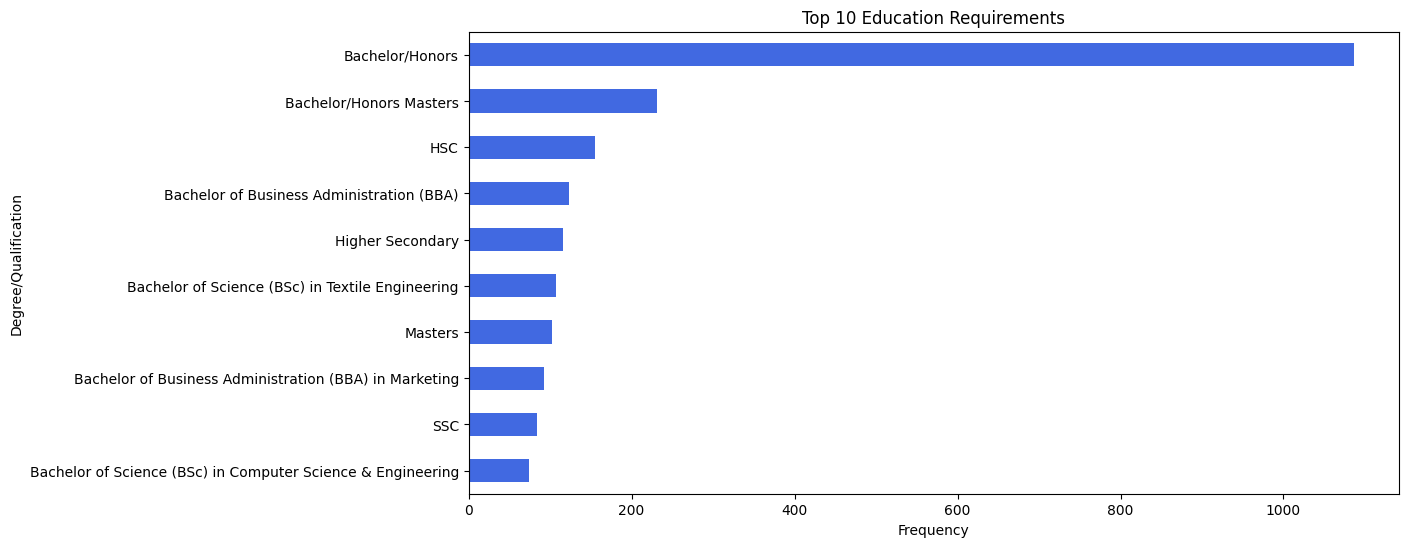

In [205]:
plt.figure(figsize=(12, 6))
df_final['EducationRequirements'].value_counts().head(10).plot(kind='barh', color='royalblue')
plt.title('Top 10 Education Requirements')
plt.xlabel('Frequency')
plt.ylabel('Degree/Qualification')
plt.gca().invert_yaxis()
plt.savefig('education_requirements.png')